# Practica PySpark ML.

Realizado por: Antonio M. Guerrero Rosa (en Google Colab).

### Importacion de Librerias, Inicio de Sesion y Carga de los Datos.

In [1]:
!pip install pyspark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=b5df76a046c1d3d1b4a3e6c1e435b60321212e5d672a36d14f5076b5887adaa1
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


#### Librerias:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyspark.pandas as ps

from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler

from pyspark.sql import functions as F

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

#### Inicio de Sesion:

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MedicalSpark').getOrCreate()

#### Carga de los Datos:

In [28]:
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
pandas_df = pd.read_csv(url)
df = ps.from_pandas(pandas_df)

### Pre-Procesamiento de los Datos.

Vamos a ver la forma general del DataFrame primero para saber con que estamos trabajando.

In [6]:
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**Descripcion**

Variable	|Definicion	|Clave
-------------------|------------------|----------
age|	Edad en Años|
sex	|Genero|	Se cambiara a 0 = Mujer/female, 1 = Hombre/male
bmi|	Indice de Masa Corporal	|	Valores "normales" entre 18.5 y 24.9
children|	Nº de Hijos	|
smoker|	Si es Fumador	|   Se cambiara a 0 = No, 1 = Si
region|	Zona en la que Vive	| Se dividira en 4 columnas segun la region y se marcara con 1 si es de esa y 0 si no
charges|	Cuanto Pago el Cliente|

In [7]:
df.shape

(1338, 7)

Vamos a analizar la cantidad de valores nulos si los hubiera.

In [8]:
df.isnull().sum(axis=0)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Analisis de los Datos.

#### Como no hay valores nulos, vamos a empezar a ver la distribucion de cada variable:

In [9]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4738.268200
50%,39.000000,30.400000,1.000000,9377.904700
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


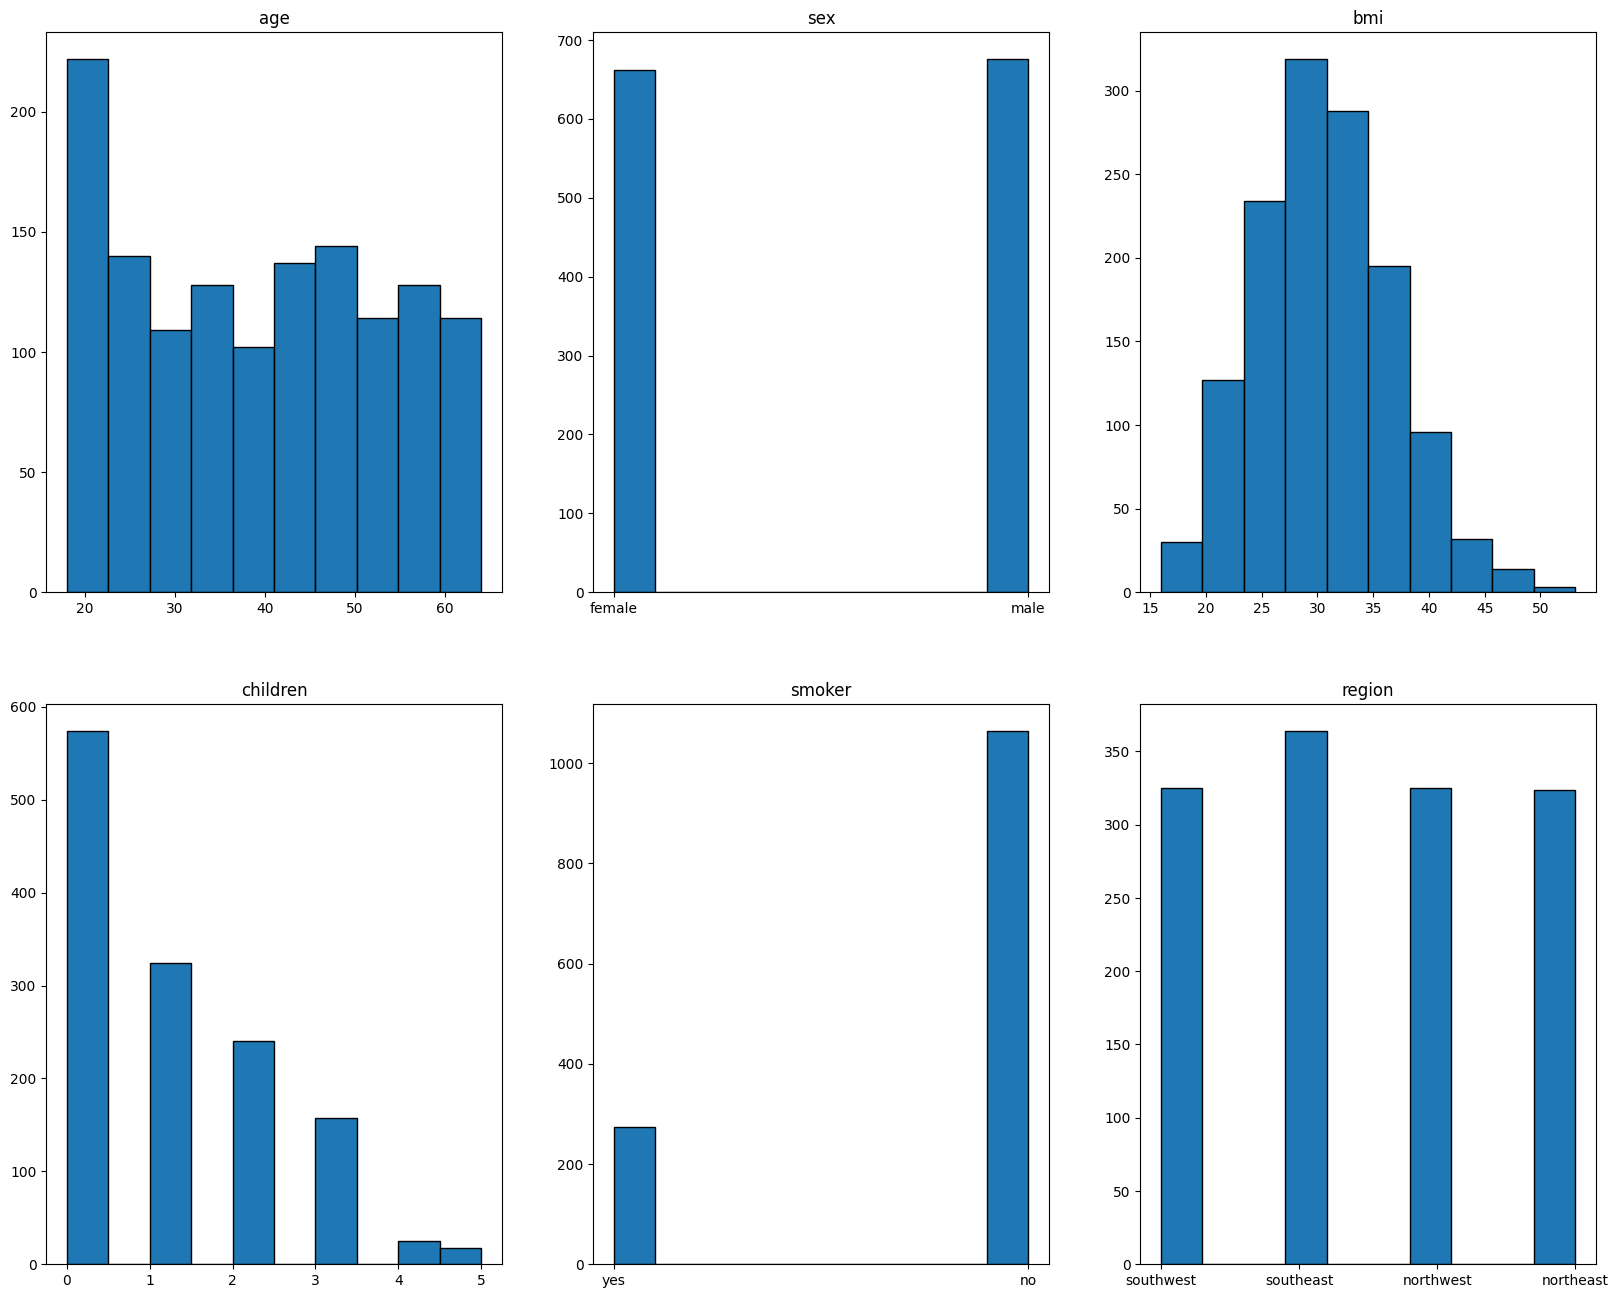

In [30]:
fig,axs = plt.subplots(2,3,figsize=(20,16))
cols = ['age','sex','bmi','children','smoker','region']
a = 0; b = 0;

for i in cols:
  axs[a, b].hist(x= df[i].to_numpy(),edgecolor='black',linewidth=1.0)
  axs[a, b].set_title(i)

  if b==2:
    a=a+1;b=0;
  else:
    b=b+1;

No hay ninguna variable que presente demasiada disparidad en los datos, por lo que podemos trabajar directamente con ellas sin aplicarles ninguna transformacion.

#### Veamos la correlacion con la variable objetivo.

In [11]:
matr_corr = df.corr()

In [12]:
matr_corr

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


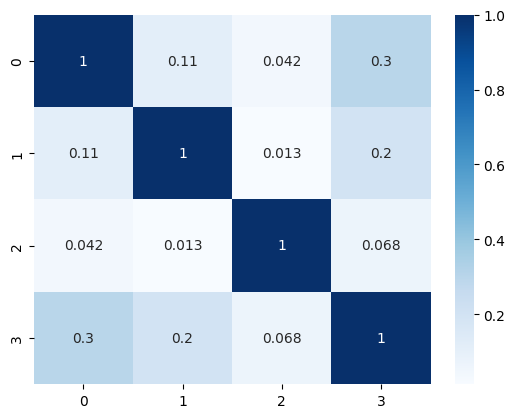

In [13]:
sns.heatmap(matr_corr.to_numpy(), annot=True, cmap = "Blues")
plt.show()

Como era de esperar, las variables edad y bmi influyen bastante en el precio del seguro.

#### Las relaciones entre variables categoricas y los cargos son las siguientes:

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driv

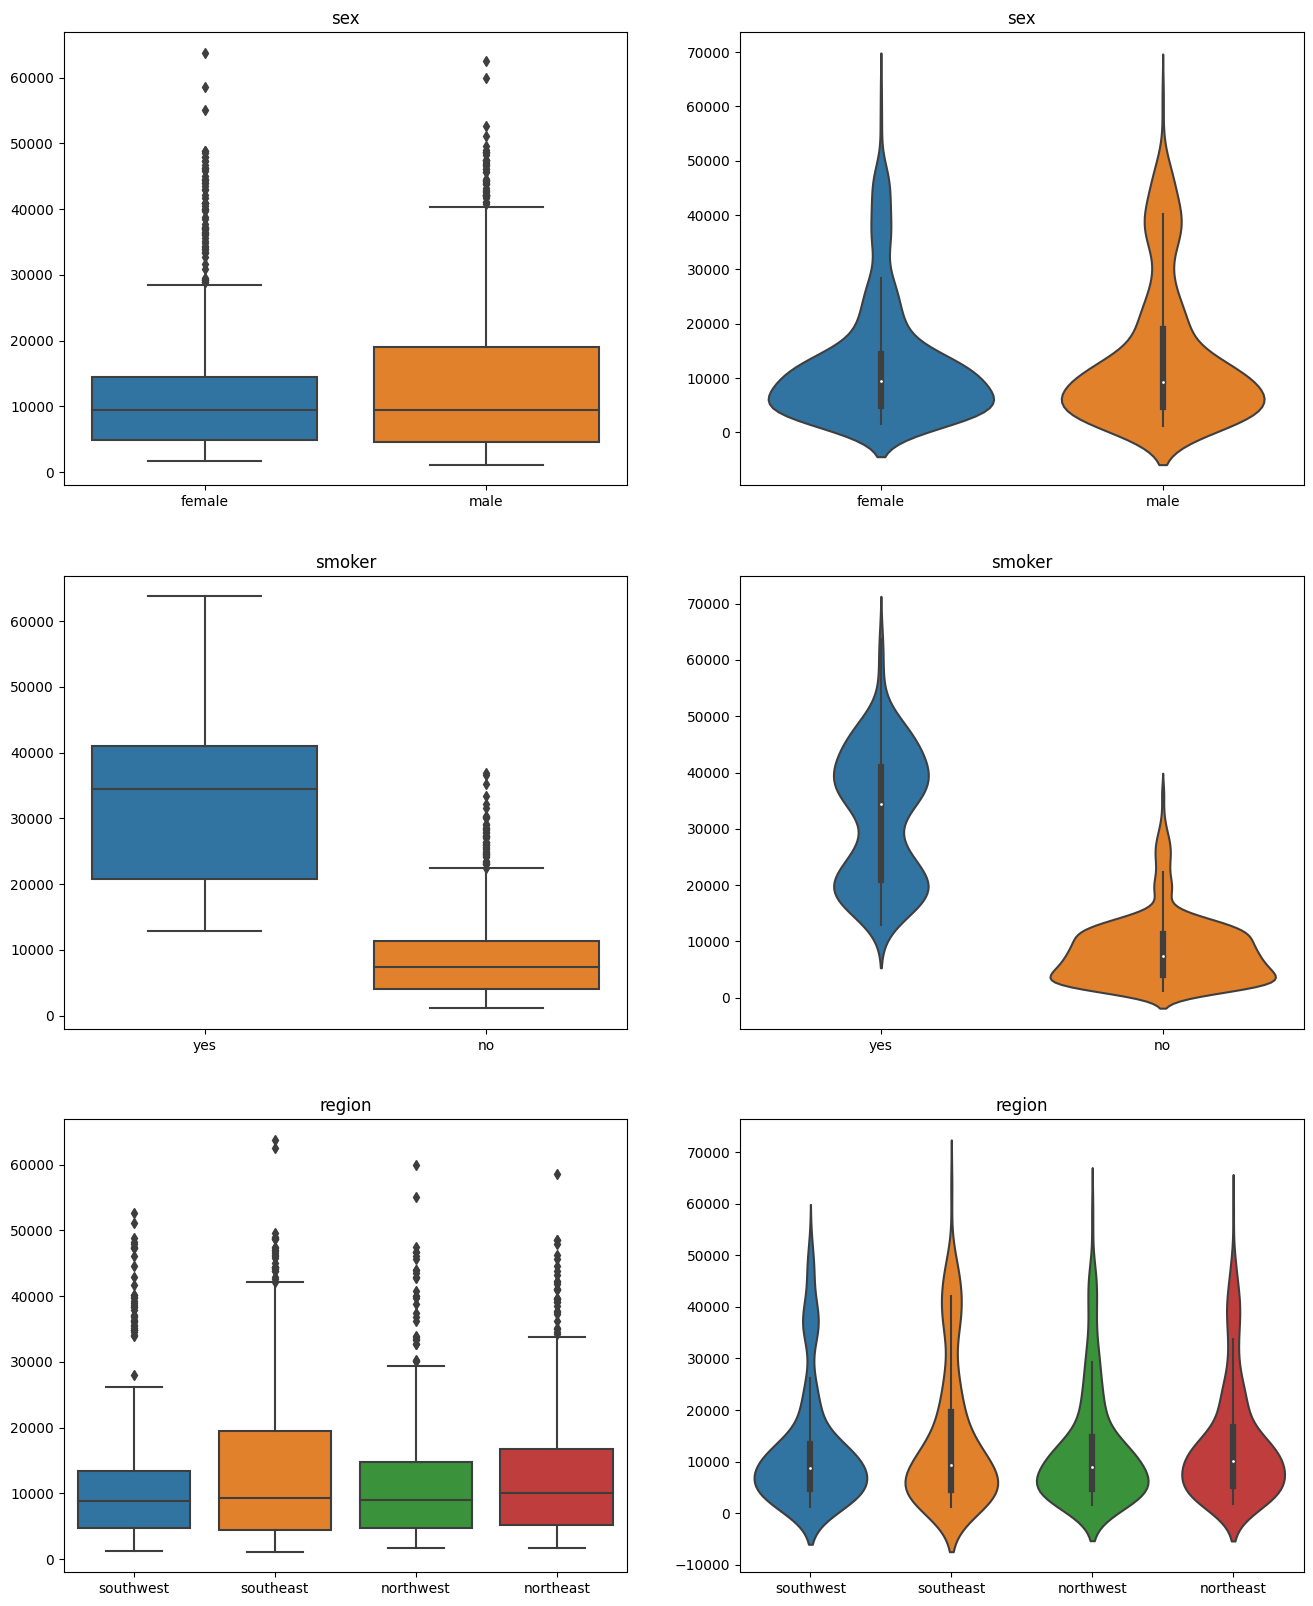

In [14]:
fig,axs = plt.subplots(3,2,figsize=(16,20))
cols_2 = ['sex','smoker','region']
a = 0; b = 0;

for i in cols_2:
  sns.boxplot(x= df[i].to_numpy(),y= df['charges'].to_numpy(),ax=axs[a,b])
  axs[a, b].set_title(i)

  b= b+1

  sns.violinplot(x= df[i].to_numpy(),y= df['charges'].to_numpy(),ax=axs[a,b])
  axs[a, b].set_title(i)

  a=a+1
  b=0

Como era de esperarse, ser o no fumador es un factor muy determinante en el cargfo del seguro. Tambien influye ligeramente el sexo, aunque menos de lo esperable. Por ultimo, si que hay una diferencia notable en la region, teniendo el sudeste las tasas mas altas, sorprendentemente.

### Spark ML

#### Vamos a empezar a tranformar las variables categoricas en variables numericas:

In [15]:
df = ps.get_dummies(df,columns=['sex','smoker','region'])


In [16]:
df = df.drop(columns=['sex_female','smoker_no'])
df.head(5)

,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,0,1
1,18,33.770,1,1725.55230,1,0,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,0,1,0,0


#### Y ahora pasamos a Spark y preparamos los datos para la regresion.

In [17]:
df_spark = df.to_spark()
df_spark.printSchema()

root
 |-- age: long (nullable = false)
 |-- bmi: double (nullable = false)
 |-- children: long (nullable = false)
 |-- charges: double (nullable = false)
 |-- sex_male: byte (nullable = false)
 |-- smoker_yes: byte (nullable = false)
 |-- region_northeast: byte (nullable = false)
 |-- region_northwest: byte (nullable = false)
 |-- region_southeast: byte (nullable = false)
 |-- region_southwest: byte (nullable = false)



/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Fijamos los indices.

In [18]:
label_indexer = StringIndexer(inputCol="charges", outputCol="label")
df_spark = label_indexer.fit(df_spark).transform(df_spark)

Construimos el vector de los datos.

In [19]:
dfInputCols = df.columns.drop('charges').to_list()
assembler = VectorAssembler(inputCols=dfInputCols, outputCol="features")
outputData = assembler.transform(df_spark).select(['features','label'])

outputData.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



Aplicamos una reescalacion a los datos para que la regresion sea mas sencilla.

In [20]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaledData = scaler.fit(outputData).transform(outputData)
Data = scaledData.drop(F.col('features'))

In [21]:
Data = Data.select('scaled_features','label')
Data = Data.withColumnRenamed("scaled_features","features")
Data.show()

+--------------------+------+
|            features| label|
+--------------------+------+
|(9,[0,1,4,8],[0.0...| 340.0|
|(9,[1,2,3,7],[0.4...| 358.0|
|[0.21739130434782...| 891.0|
|(9,[0,1,3,6],[0.3...| 500.0|
|(9,[0,1,3,6],[0.3...| 783.0|
|(9,[0,1,7],[0.282...| 766.0|
|(9,[0,1,2,7],[0.6...|1212.0|
|(9,[0,1,2,6],[0.4...|1152.0|
|[0.41304347826086...|1085.0|
|(9,[0,1,6],[0.913...| 641.0|
|(9,[0,1,3,5],[0.1...| 612.0|
|(9,[0,1,4,7],[0.9...| 625.0|
|(9,[0,1,3,8],[0.1...| 389.0|
|(9,[0,1,7],[0.826...|  68.0|
|[0.19565217391304...| 802.0|
|[0.02173913043478...| 393.0|
|(9,[0,1,2,5],[0.7...|  47.0|
|(9,[0,1,3,5],[0.1...| 543.0|
|(9,[0,1,3,8],[0.8...|  39.0|
|[0.26086956521739...| 752.0|
+--------------------+------+
only showing top 20 rows



Y por ultimo, dividimos los datos en dos partes: una para entrenar el modelo y otra para predecir.

In [22]:
(trainingData, testData) = Data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 941
Test Dataset Count: 397


#### Regresion Lineal.

Montamos y entrenamos el modelo.

In [23]:
from pyspark.ml.regression  import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(trainingData)

Comprobamos el indice de acierto del modelo.

In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = lrModel.transform(testData)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
evaluator.evaluate(predictions)

0.6085858585858586

Es decir que este modelo ha acertado en un 60% los cargos asociados a cada paciente. Vamos a intentar mejorarlo.

In [25]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)

cvModel = crossval.fit(Data)

Ya han sido ajustados los parametros, veamos si mejora el indice de acierto.

In [26]:
predictions = cvModel.transform(testData)
evaluator.evaluate(predictions)

0.6439393939393939

No ha mejorado, lo cual significa que ya teniamos la mejor version del modelo. Seguramente un indice tan bajo se deba a la falta de mas datos en cada paciente y a la dificultad asociada al propio modelo.